# SVD-Rectification robustness to noise

The goal of this notebook is to verify how much the SVD rectification is robust to noise applied to the image of the circluar points

This is done in few steps:
- use the simulator to create an image
- knowing the real image of the circular points, rectify it using the SVD method (standard)
- applying noise to the image of the circular points, rectify it using the SVD method
- compare the two results

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy.linalg as la
import seaborn as sns
sns.set_theme()
# autoreload   
%load_ext autoreload
%autoreload 2

In [4]:
from HomoTopiContinuation.DataStructures.datastructures import Circle, Conic, SceneDescription, Homography, Conics
import HomoTopiContinuation.SceneGenerator.scene_generator as sg
from HomoTopiContinuation.Rectifier.rectifier import Rectifier
from HomoTopiContinuation.Losser.CircleLosser import CircleLosser



In [5]:
def sceneDefinition() -> SceneDescription:
    # Parameters
    f = 1
    theta = 10

    # Define the circles
    c1 = Circle(
        np.array([10, 100]), 5)
    c2 = Circle(
        np.array([50, 100]), 5)
    c3 = Circle(
        np.array([90, 100]), 5)

    print("Circle 1:")
    print(c1.to_conic().M)
    print([float(p) for p in c1.to_conic().to_algebraic_form()])
    print("Circle 2:")
    print(c2.to_conic().M)
    print([float(p) for p in c2.to_conic().to_algebraic_form()])
    print("Circle 3:")
    print(c3.to_conic().M)
    print([float(p) for p in c3.to_conic().to_algebraic_form()])

    offset = np.array([0, 0, 1])

    return SceneDescription(f, theta, offset, c1, c2, c3)

In [6]:
scene_description = sceneDefinition()

Circle 1:
[[    1     0   -10]
 [    0     1  -100]
 [  -10  -100 10075]]
[1.0, 0.0, 1.0, -20.0, -200.0, 10075.0]
Circle 2:
[[    1     0   -50]
 [    0     1  -100]
 [  -50  -100 12475]]
[1.0, 0.0, 1.0, -100.0, -200.0, 12475.0]
Circle 3:
[[    1     0   -90]
 [    0     1  -100]
 [  -90  -100 18075]]
[1.0, 0.0, 1.0, -180.0, -200.0, 18075.0]


In [7]:
img = sg.SceneGenerator().generate_scene(scene_description)

In [8]:
H = img.h_true.H

In [9]:
circular_points_true = img.imCircularPoints
# Apply Gaussian noise to the image of the circular points
noise = 0.00001
circular_points_noisy = circular_points_true + np.random.normal(0, noise, circular_points_true.shape)

In [10]:
def compute_h_from_svd(imDCCP: np.ndarray) -> Homography:
        """
        Compute the Homography from the SVD of the image dual conic.
        """

        assert imDCCP.shape == (3, 3), "imDCCP must be a 3x3 matrix"


        # Singular value decomposition
        U, S, Vt = la.svd(imDCCP)
        if np.any(S < 0):
            raise ValueError(
                f"imDCCP is not positive definite! No homography can be computed. Singular values: {S}")


        # Compute the homography
        H = np.diag(1.0 / np.sqrt([S[0], S[1], 1.0])) @ U.T

        return Homography(H)

In [11]:
def compute_eccentricities(circular_points, img, noise: float = 0, threshold: float = 1e-6):
    #apply noise to the circular points
    if noise > 0:
        circular_points = circular_points + np.random.normal(0, noise, circular_points.shape)
    # extract the circular points
    I = circular_points[:, 0]
    J = circular_points[:, 1]
    # normalize the points
    I /= I[-1]
    J /= J[-1]
    imDCCP = I[:,None] @ J[:,None].T + J[:,None] @ I[:,None].T
    imDCCP = np.where(np.imag(imDCCP) < threshold, np.real(imDCCP), imDCCP)
    imDCCP[np.abs(imDCCP) < threshold] = 0.0
    #compute the homography
    H = compute_h_from_svd(imDCCP)
    conics = img.C_img
    C1 = conics.C1.applyHomography(H)
    C2 = conics.C2.applyHomography(H)
    C3 = conics.C3.applyHomography(H)
    return CircleLosser.computeCircleLoss(None, Conics(C1, C2, C3))
    

In [12]:
noNoise_max_eccentricity = max(compute_eccentricities(circular_points_true, img))
loss_noise = []
for noise in np.linspace(0, 0.003, 1000): 
    ecc = compute_eccentricities(circular_points_noisy, img, noise)
    loss = abs(max(ecc) - noNoise_max_eccentricity)**2
    loss_noise.append(loss)


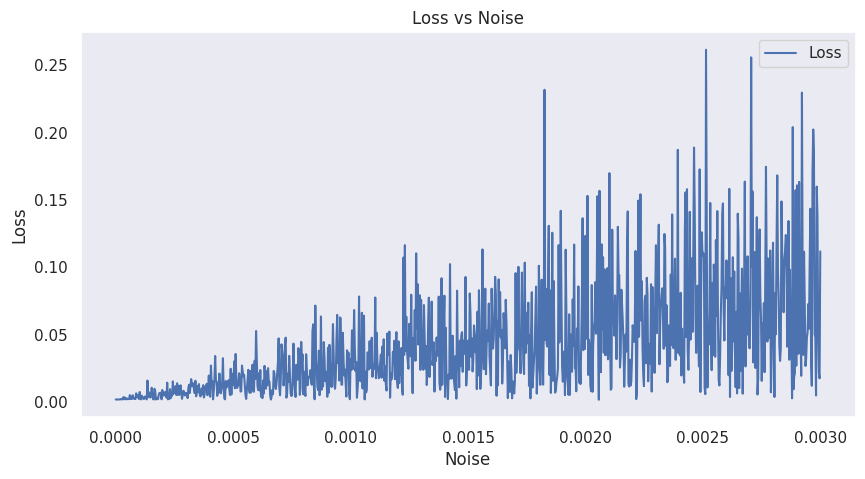

In [13]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 0.003, 1000), loss_noise, label='Loss')
plt.xlabel('Noise')
plt.ylabel('Loss')
plt.title('Loss vs Noise')
plt.legend()
plt.grid()
plt.show()